In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import nltk, csv

In [2]:
vectorizer_type = 'count'
num_words = 20000
# lr | gnb | mnb | lsvc | rf
ml_model = 'lr'
n = 1

In [3]:
df = pd.read_csv('data/blurb/blurb_top.csv',delimiter=',',encoding='utf-8')
label_map = {}
index = 0
for label_item in df.label:
    try:
        label_map[label_item]
    except KeyError:
        label_map[label_item] = index
        index = index + 1
df.replace(label_map, inplace=True)

<Figure size 576x432 with 0 Axes>

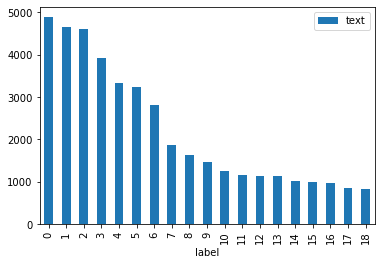

In [4]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').count().plot.bar(ylim=0)
plt.show()

In [5]:
df.text=df.text.fillna(' ')
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, train_size=0.8, stratify=df.label)

In [6]:
print(df.shape, len(label_map))

(41719, 2) 19


In [7]:
if vectorizer_type == 'count':
    vectorizer = CountVectorizer(stop_words=None, max_df=.1, max_features=num_words)
elif vectorizer_type == 'tfidf':
    vectorizer=TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english', use_idf=True, max_df=.1, max_features=num_words)
vectorizer = vectorizer.fit(X_train)

In [8]:
X_train=vectorizer.transform(X_train)
X_test=vectorizer.transform(X_test)

In [9]:
if ml_model == 'lr':
    # Logistic regression model
    print('logistic regression')
    classifier = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter=200)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)
elif ml_model == 'gnb':
    # Gaussian Naive Bayes Model
    print('gaussian naive bayes')
    classifier = GaussianNB()
    classifier.fit(X_train.todense(), y_train)
    y_pred = classifier.predict(X_test.todense())
    y_pred_proba = classifier.predict_proba(X_test.todense())
elif ml_model == 'mnb':
    print('multinomial naive bayes')
    classifier = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)
elif ml_model == 'lsvc':
    print('linear support vector machine')
    classifier = LinearSVC(random_state=0, tol=1e-05, probability=True)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
elif ml_model == 'rf':
    print('random forest classifier')
    classifier = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)

logistic regression


In [10]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 2225
Accuracy: 0.73


In [11]:
pred_in=vectorizer.transform(["Sehr geehrte Damen und Herren,     meine für die Urkundenrolle zuständigen Kolleginnen, Frau <NAME> und Frau <NAME>, sprachen mich heute wegen folgender Problematik an:     Frau <NAME> und Frau <NAME> wollten heute Nachmittag das erste Mal seit der Migration die Urkundenrolle als verbindlichen Druck ausdrucken. Während des jeweiligen Druckvorgangs wurden allerdings keine Ausdrucke in Papierform erzeugt, sondern es wurde lediglich angeboten, eine PDF-Datei zu erzeugen. Diese ließ sich nach dem Abspeichern allerdings nicht öffnen.     Wir haben dann den Vorgang abgebrochen und einen Wiederholungsdruck ausgelöst, der ordnungsgemäß - jedoch mit Wasserzeichen „WIEDERHOLUNGSDRUCK“ - ausgedruckt worden ist.     Ich bitte um Überprüfung und Rückmeldung an diesen Verteiler.     Rufen Sie mich gerne an, falls Ihrerseits Rückfragen bestehen.     Wie immer, besten Dank!     "])
if ml_model == 'lr' or ml_model == 'mnb':
    classifier.predict_proba(pred_in)
    print(classifier.predict(pred_in))
elif ml_model == 'gnb' or ml_model == 'rf':
    classifier.predict_proba(pred_in.todense())
    print(classifier.predict(pred_in.todense()))
elif ml_model == 'lsvc':
    print(classifier.predict(pred_in))

[1]


In [12]:
# label_map

In [13]:
# y_pred_proba.shape
# type(y_pred_proba)
# y_pred

In [14]:
print(ml_model, vectorizer_type, n)
matches = 0
for x in range(0, y_pred_proba.shape[0]):
    if y_test.iloc[x] in np.argsort(y_pred_proba[x])[::-1][:n]:
        matches = matches + 1
top_n_accuracy = matches / y_test.shape[0]
print('Misclassified samples: {}'.format(y_test.shape[0] - matches))
print('Accuracy: {:.2f}'.format(top_n_accuracy))

lr count 1
Misclassified samples: 2225
Accuracy: 0.73
